In [1]:
import numpy as np
import cupy as cp
from types import SimpleNamespace
from utils import *
from rec import Rec

# Init data sizes and parameters 

In [2]:
n = 128  # object size in each dimension
ntheta = 128  # number of angles (rotations)
theta = np.linspace(0, np.pi, ntheta).astype('float32')  # projection angles

ndist = 4 # number of distances from the focal spot in holotomography
detector_pixelsize = 3e-6 # detector pixel size
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length

focusToDetectorDistance = 1.208  # focus to detector distance [m]
sx0 = -2.493e-3
z1 = np.array([1.5335e-3, 1.7065e-3, 2.3975e-3, 3.8320e-3])[:ndist]-sx0 # distances
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance # adjusted distances
magnifications = focusToDetectorDistance/z1 # magnifications
voxelsize = detector_pixelsize/magnifications[0]*2048/n/2  # object voxel size

norm_magnifications = magnifications/magnifications[0] # normalized magnifications
distances = distances*norm_magnifications**2 # readjusted distances
z1p = z1[0]  # positions of the probe for reconstruction

z2p = z1-np.tile(z1p, len(z1))
# magnification when propagating from the probe plane to the detector
magnificationsp = (z1p+z2p)/z1p
# propagation distances after switching from the point source wave to plane wave,
distancesp = (z1p*z2p)/(z1p+z2p)
norm_magnifications2 = magnificationsp/(z1p/z1[0])  # normalized magnifications
# scaled propagation distances due to magnified probes
distancesp = distancesp*norm_magnifications2**2
distancesp = distancesp*(z1p/z1)**2

npsi = int(np.ceil(n/norm_magnifications[-1]/8))*8  # reconstructed object size based on magnification and detector size
print(distances+distancesp)


[0.00401308 0.00401308 0.00401308 0.00401308]


# Create solver class

In [3]:
args = SimpleNamespace()
args.n = n
args.ndist = ndist
args.ntheta = ntheta
args.npsi = npsi

args.voxelsize = voxelsize
args.wavelength = wavelength
args.distance = distances
args.distancep = distancesp
args.rotation_axis = args.npsi/2

args.theta = theta
args.norm_magnifications = norm_magnifications
# create class
cl_rec = Rec(args)


## Read object and plot orthogonal views

In [ ]:
u=cp.load('u.npy')

## Compute tomographic projection data via the Fourier based method, $\mathcal{R}u$:

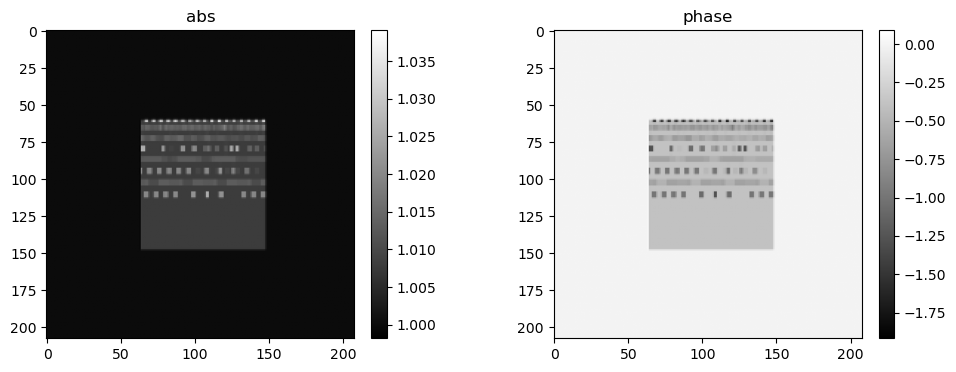

In [6]:
psi = cl_rec.expR(cl_rec.R(u))
mshow_polar(psi[0],True)

## Read probe

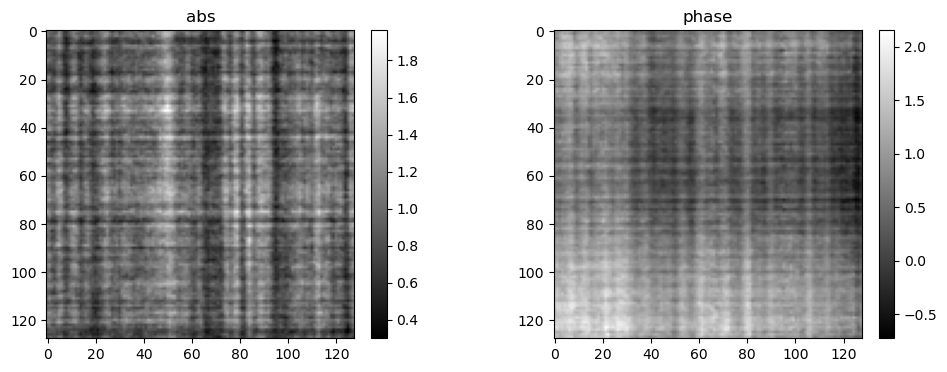

In [7]:
q=cp.load('q.npy')
mshow_polar(q[0],True)

# Shifts/drifts

In [8]:
r = cp.load('shifts.npy')
rerr = cp.load('shifts_err.npy')

# Simulate data

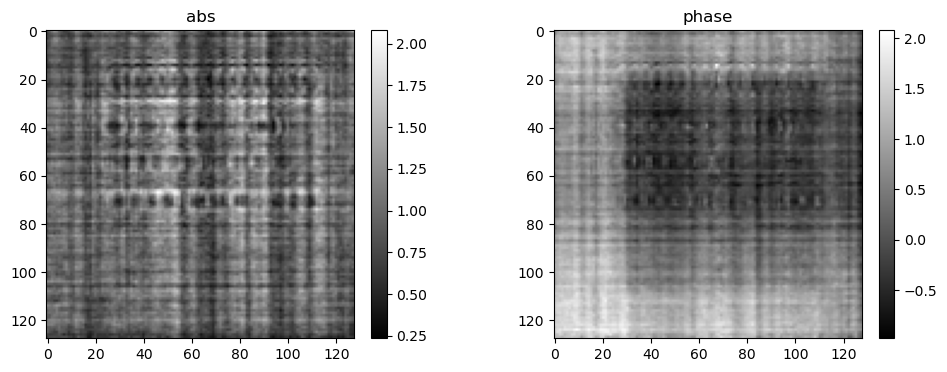

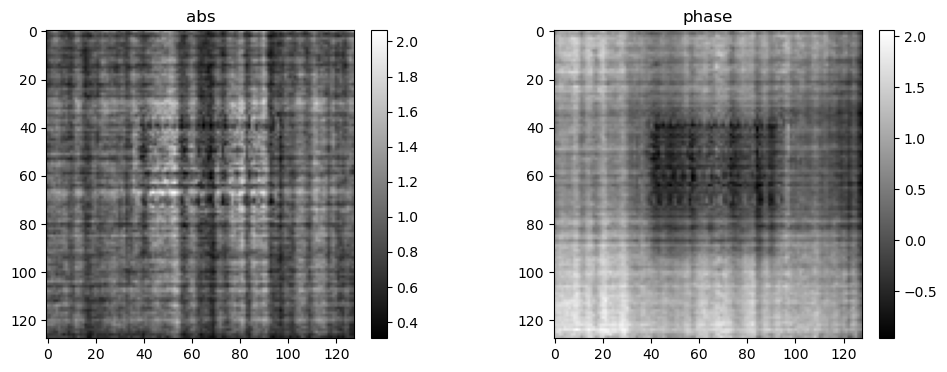

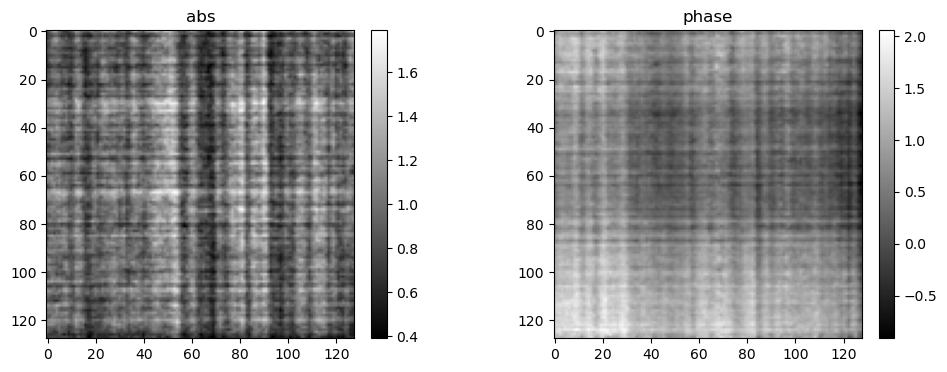

(1, 128, 128)


In [9]:
data = cl_rec.fwd(r+rerr,u,q)
ref = cl_rec.fwd(r*0,u*0,q)[0,0:1]
mshow_polar(data[0,0],True)
mshow_polar(data[0,3],True)
mshow_polar(ref[0],True)
print(ref.shape)

### Take squared absolute value to simulate data on the detector and a reference image

In [10]:
data = np.abs(data)**2
ref = np.abs(ref)**2

### Visualize data

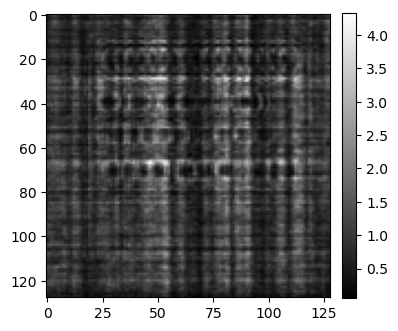

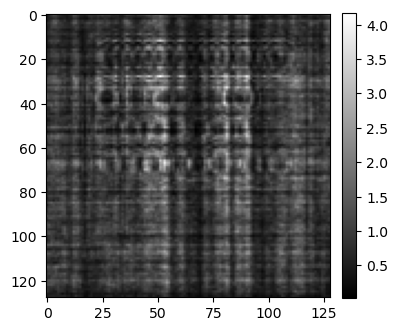

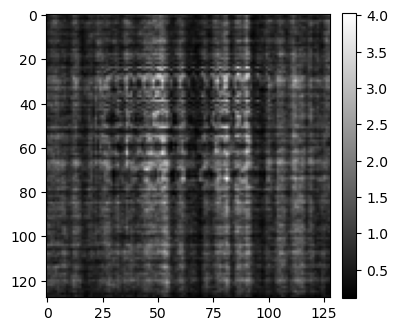

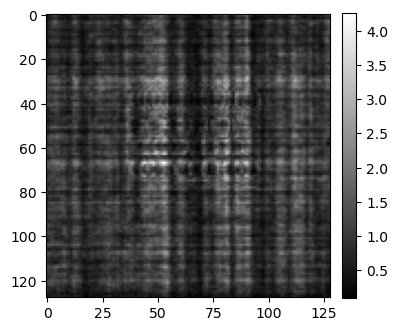

In [11]:
for k in range(ndist):
    mshow(data[0,k],True)


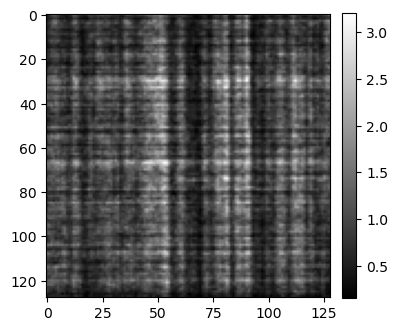

In [12]:
mshow(ref[0],True)

### Save data, reference images

In [13]:
np.save('data',data)
np.save('ref',ref)
